In [1]:
import numpy as np
import pandas as pd
import sklearn
import tqdm
from mat2vec.processing import MaterialsTextProcessor
from pymatgen.analysis import magnetism
from sklearn import preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.pipeline import Pipeline
import time
from pathlib import Path
import matplotlib.pyplot as plt
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
from pymatgen import Composition
from sklearn.feature_selection import (
    RFE,
    SelectKBest,
    SelectPercentile,
    VarianceThreshold,
    chi2,
    f_classif,
    f_regression,
    mutual_info_classif,
)
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve

C:\Users\giovanni\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.unsupervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
'''
Class to be imported in pipeline (below) for dropping the most correlated columns, preventing data leakage.
'''

class MyDecorrelator(BaseEstimator, TransformerMixin): 
    
    def __init__(self, threshold):
        self.threshold = threshold
        self.correlated_columns = None

    def fit(self, X, y=None):
        correlated_features = set()  
        X = pd.DataFrame(X)
        corr_matrix = X.corr()
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if abs(corr_matrix.iloc[i, j]) > self.threshold: # we are interested in absolute coeff value
                    colname = corr_matrix.columns[i]  # getting the name of column
                    correlated_features.add(colname)
        #print(np.shape(pd.DataFrame(X).drop(labels=correlated_features, axis=1)))
        #print(pd.DataFrame(X).drop(labels=correlated_features, axis=1))
        self.correlated_features = correlated_features
        return self

    def transform(self, X, y=None, **kwargs):
        return (pd.DataFrame(X)).drop(labels=self.correlated_features, axis=1)

In [3]:
Elements = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'P', 
    'S','Cl','Ar','K','Ca','Sc','Ti','V','Cr','Mn','Fe','Co','Ni','Cu','Zn',
    'Ga','Ge','As','Se','Br','Kr','Rb','Sr','Y','Zr','Nb','Mo','Tc','Ru',
    'Rh','Pd','Ag','Cd','In','Sn','Sb','Te','I','Xe','Cs','Ba','La','Ce',
    'Pr','Nd','Pm','Sm','Eu','Gd','Tb','Dy','Ho','Er','Tm','Yb','Lu','Hf',
    'Ta','W','Re','Os','Ir','Pt','Au','Hg','Tl','Pb','Bi','Po','At','Rn',
    'Fr','Ra','Ac','Th','Pa','U','Np','Pu','Am','Cm','Bk','Cf','Es','Fm',
    'Md','No','Lr','Rf','Db','Sg','Bh','Hs','Mt','Ds','Rg','Cn','Uut',
    'Fl','Uup','Lv','Uus','Uuo']

SuperCon = pd.read_excel(r'C:\\Users\\giovanni\\Desktop\\new_supercon.xlsx')
SuperCon = SuperCon[['element', 'tc', 'year.1']]
SuperCon.rename(columns = {'element':'Components'}, inplace = True)
SuperCon.rename(columns = {'tc':'Tc'}, inplace = True)
SuperCon.rename(columns = {'year.1':'year'}, inplace = True)
        
for i in range(len(SuperCon)):
    if '-' in SuperCon['Components'].iloc[i]:
        SuperCon['Tc'][i] = np.NaN

for i in range(len(SuperCon)):
    if ',' in SuperCon['Components'].iloc[i]:
        SuperCon['Tc'][i] = np.NaN
        
for i in range(len(SuperCon)):
    if '+' in SuperCon['Components'].iloc[i]:
        SuperCon['Tc'][i] = np.NaN
import re
S2 = set(Elements)

for i in range(len(SuperCon)):
    list_1 = re.findall('[A-Z][a-z]|[A-Z]', SuperCon['Components'].iloc[i])
    S1 = set(list_1)
    
    if len(S1) > len(S1.intersection(S2)):
        if not SuperCon['Tc'].isna().iloc[i]:
            print(SuperCon['Components'].iloc[i])

            SuperCon['Tc'].iloc[i] = np.NaN


Yb16Ba1Cu2Oz
Yb1.8Ba0.2Cu1Oz
Yb6Ba1Cu1Oz
Yb1.62La0.18Ba0.18Sr0.02Cu1Oz
Y0.4Ba0.6Cu1OX
Y0.4Ba0.6Cu1OX
Er0.5Ba0.5Cu1OX
Tm0.35Ba0.65Cu1OX
Tm0.3Ba0.7Cu1OX
Tm0.25Ba0.75Cu1OX
Tm0.2Ba0.8Cu1OX
Y1Ba2Cu3OX
Nd0.4Ba0.6Cu1OX
Nd2Ba3Cu5OX
Sm1Ba2Cu3OX
Gd2Ba3Cu5OX
Y1Ba2Cu3OX
Y1Ba2Cu3OX
Y0.8Ba1.2Cu1OX
Y0.6Ba0.9Cu1OX
Yb1.6La0.2Ba0.2Cu1Oz
Y0.4Ba0.6Cu1OX
Er1Ba2Cu3OX
Ho1Ba2Cu3OX
Gd1Ba2Cu3OX
Eu1.5Ba1.5Cu3Oz
Gd1.5Ba1.5Cu3Oz
Y1.5Ba1.5Cu3Oz
Yb1.5Ba1.5Cu3Oz
Y1Ba2Cu3F0.066Oz
Y1Ba2Cu3F0.066Oz
Y1Ba2Cu3F0.165Oz
Y1Ba2Cu3F0.016Oz
Y1Ba2Cu3F0.033Oz
Y1Ba2Cu3F0.05Oz
Y1Ba2Cu3Oz
Y1Ba2Cu3Oz
Gd1Ba2Cu3Oz
Er1Ba2Cu3OX
Dy1Ba2Cu3OX
Ho1Ba2Cu3OX
Y1Ba2Cu3OX
La1.85Sr0.15Cu0.97Ni0.03OX
Tl2Ca2Ba1Cu3OX
Tl2Ca2Ba2Cu3OX
Y1Ba2Cu3Oz
Y1Ba2Cu2.85Ti0.15Oz
Y1Ba2Cu2.7Ti0.3Oz
Y1Ba2Cu2.55Ti0.45Oz
Y1Ba2Cu2.4Ti0.6Oz
Y1Ba2Cu2.25Ti0.75Oz
Y1Ba2Cu2.1Ti0.9Oz
Bi1Sr1Ca1Cu2Oz
Bi2Sr1.8Ca1.2Cu2Oz
Bi2Sr3Ca4Cu8Oz
Bi1Sr1Ca1Cu2Oz
Gd1Ba2Cu3OX
Gd1Ba1.8Sr0.2Cu3OX
Gd1Ba1.6Sr0.4Cu3OX
Gd1Ba1.4Sr0.6Cu3Oz
Gd1Ba1.2Sr0.8Cu3Oz
Gd1Ba1Sr1Cu3Oz
Bi1Ca1Sr1Cu2Oz
Bi1Ca1Sr1Cu2Oz
Eu1B

Ca1La1Ba1Cu3Oz
Ca0.9Cd0.1La1Ba1Cu3Oz
Ca0.8Cd0.2La1Ba1Cu3Oz
Ca0.7Cd0.3La1Ba1Cu3Oz
Ca0.6Cd0.4La1Ba1Cu3Oz
Ca0.5Cd0.5La1Ba1Cu3Oz
Ca0.4Cd0.6La1Ba1Cu3Oz
Ca0.3Cd0.7La1Ba1Cu3Oz
Ca0.25Cd0.75La1Ba1Cu3Oz
Hg0.7Mo0.3Sr2Cu1Oz
Hg0.8Re0.2Sr2Ca0.7Y0.3Cu2Oz
Hg1Sr2Ca0.7Y0.3Cu1.8Re0.2Oz
Hg1Sr2Cu0.9Re0.1Oz
Hg0.7Mo0.3Sr2Ca0.7Y0.3Cu2Oz
Hg0.7Mo0.3Sr2Ca0.5Y0.5Cu2Oz
Hg0.7Mo0.3Sr2Ca0.3Y0.7Cu2Oz
C1Ba2.5Ca2.5Cu4Oz
Ba1.96Ca0.12Y0.92C0.21Cu2.79Oz
Ga1Sr2Ca3Cu4OZ
Hg1.46Cl1.46Bi2Sr2Ca1Cu2Oz
Bi1.6Pb0.4Sr2Ca2Cu3Oz
Bi1.6Pb0.4Sr2Ca2Cu3F0.65Oz
Bi1.6Pb0.4Sr2Ca2Cu3F0.85Oz
Bi1.6Pb0.4Sr2Ca2Cu3F0.85Oz
Al1Sr2Ca3Cu4Oz
Al1Sr2Ca5Cu5Oz
Bi2Sr1.9Cu2.1Ox
Hg0.95Mo0.05Sr2Ca2Cu3Oz
Hg0.5Pb0.5Sr2Ca2Cu3Oz
Hg0.5Pb0.5Sr2Ca2Cu3Oz
La1.5Ba1.5Sr1.5Cu3Oz
La1.5Ba1.3Sr0.2Cu3Oz
La1.5Ba1.2Sr0.3Cu3Oz
La1.5Ba1.1Sr0.4Cu3Oz
La1.1Ba1.7Sr0.2Cu3Oz
La1.1Ba1.6Sr0.3Cu3Oz
La1.1Ba1.5Sr0.4Cu3Oz
La1Ba1.6Sr0.4Cu3Oz
La1.2Ba1.8SrCu3Oz
La1.2Ba1.6Sr0.2Cu3Oz
La1.2Ba1.5Sr0.3Cu3Oz
La1.2Ba1.4Sr0.4Cu3Oz
Tl1HgSr2Ba2Cu2Co3Oz
Tl0.8Hg0.2Sr2Ba2Cu2Co3Oz
Tl0.7Hg0.3Sr2Ba2Cu2Co3Oz
Tl0.

Bi2Sr2Ca1Cu2OZ
Bi2Sr2Ca1Cu2OZ
Bi2Sr2Ca1Cu2OZ
Hg0.9Re0.1Ba2Ca2Cu3OZ
Hg0.9Re0.1Ba2Ca2Cu3OZ
Hg0.8Re0.2Ba2Ca2Cu3OZ
Bi2Sr2Ca1Cu2OZ
H1Bi2Sr2Ca1Cu2OZ
Tl0.6Pb0.4Sr1.7Ba0.3Ca1Cu2OZ
Tl0.6Pb0.4Sr1.7Ba0.3Ca1Cu2OZ
Y0.5Ca0.5Ba2Cu3OZ
I1Bi2Sr1.5Ca1.5Cu2OZ
Hg1I2Bi2Sr1.5Ca1.5Cu2OZ
Py2C1H24Hg1I4Bi2Sr1.5Ca1.5Cu2OZ
Py2C2H26Hg1I4Bi2Sr1.5Ca1.5Cu2OZ
Py2C4H210Hg1I4Bi2Sr1.5Ca1.5Cu2OZ
Py2C6H214Hg1I4Bi2Sr1.5Ca1.5Cu2OZ
Py2C8H218Hg1I4Bi2Sr1.5Ca1.5Cu2OZ
Py2C10H224Hg1I4Bi2Sr1.5Ca1.5Cu2OZ
Py2C12H226Hg1I4Bi2Sr1.5Ca1.5Cu2OZ
Py2C2H24Hg1I4Bi2Sr1.6La0.4Cu1OZ
Py2C8H210Hg1I4Bi2Sr1.6La0.4Cu1OZ
Py2C16H218Hg1I4Bi2Sr1.6La0.4Cu1OZ
Py2C24H226Hg1I4Bi2Sr1.6La0.4Cu1OZ
I1Bi2Sr1.6La0.4Cu1OZ
Hg1I2Bi2Sr1.6La0.4Cu1OZ
Tl2Ba2Ca2Cu3OZ
Tl2Ba2Ca2Cd0.1Cu3OZ
Tl2Ba2Ca2Cd0.2Cu3OZ
Tl2Ba2Ca2Cd0.3Cu3OZ
Y0.8Ca0.2Ba2Cu3OZ
Y0.8Ca0.2Ba0.95La0.05Cu3OZ
Y0.8Ca0.2Ba0.9La0.1Cu3OZ
Y0.8Ca0.2Ba0.85La0.15Cu3OZ
Y0.8Ca0.2Ba0.8La0.2Cu3OZ
Y0.8Ca0.2Ba0.75La0.25Cu3OZ
Y0.8Ca0.2Ba0.7La0.3Cu3OZ
Y0.8Ca0.2Ba0.6La0.4Cu3OZ
Y0.8Ca0.2Ba0.5La0.5Cu3OZ
Hg1.2Tl0.8Ba2Ca2Cu3OZ
Hg1.2T

Bi1.86Pb0.14Sr2Ca1Cu2Oz
Bi1.8Pb0.2Sr2Ca1Cu2Oz
Bi1.34Pb0.66Sr2Ca2Cu3Oz
Bi2Sr2Ca1Cu2Oz
Bi2Sr2Ca0.9Nd0.1Cu2Oz
Bi2Sr2Ca0.8Nd0.2Cu2Oz
Bi2Sr2Ca0.7Nd0.3Cu2Oz
Bi2Sr2Ca0.6Nd0.4Cu2Oz
Bi2Sr2Ca0.5Nd0.5Cu2Oz
Bi2Sr2Ca0.9Y0.1Cu2Oz
Bi2Sr2Ca0.8Y0.2Cu2Oz
Bi2Sr2Ca0.7Y0.3Cu2Oz
Bi2Sr2Ca0.6Y0.4Cu2Oz
Bi2Sr2Ca0.5Y0.5Cu2Oz
Y1Ba1.8Cu3Oz
Y1Ba1.9Cu3Oz
Y1Ba2Cu3Oz
Y1Ba2.1Cu3Oz
Y1Ba2.2Cu3Oz
Pb0.63Cu2.27Sr1.9Cd0.1Y0.79Ca0.21Oz
Pb0.63Cu2.27Sr1.8Cd0.2Y0.79Ca0.21Oz
Pb0.63Cu2.27Sr1.75Cd0.25Y0.79Ca0.21Oz
Pb0.63Cu2.27Sr1.7Cd0.3Y0.79Ca0.21Oz
Pb0.63Cu2.27Sr0.65Cd0.35Y0.79Ca0.21Oz
Pb0.63Cu2.27Sr1.6Cd0.4Y0.79Ca0.21Oz
Pb0.63Cu2.27Sr1.5Cd0.5Y0.79Ca0.21Oz
Pb0.63Cu2.27Sr2Y0.79Ca0.21Oz
Pb0.63Cu2.27Sr1.79Ca0.21Y0.79Ca0.21Oz
Pb0.63Cu2.27Sr1.79Cd0.21Y0.79Ca0.21Oz
Y1Ba2Cu3Oz
Y1Ba2Cu2.85Au0.15Oz
Y1Ba2Cu2.7Au0.3Oz
Bi1.7Pb0.3Sr2Ca2Cu3Oz
Bi1.7Pb3Sr2Ca2Cu3Cs0.1Oz
Bi1.7Pb0.3Sr2Ca2Cu3Cs0.2Oz
Bi1.7Pb0.3Sr2Ca2Cu3Cs0.3Oz
Bi1.7Pb0.3Sr2Ca2Cu3Cs0.4Oz
Bi1.7Pb0.3Sr2Ca2Cu3Cs0.5Oz
Bi1.7Pb0.3Sr2Ca2Cu3Cs0.6Oz
Bi1.7Pb0.3Sr2Ca2Cu3Cs0.7Oz
Bi1.7Pb0.3Sr2Ca2Cu

Li0.48M0.3Hf1N1Cl1
Li0.5M0.3Hf1N1Cl1
Li0.48M0.3Hf1N1Cl1
Li0.16M1Zr1N1Cl1
Li0.16M1Zr1N1Cl1
Li0.15M0.08Zr1N1Cl1
Li0.18M0.15Zr1N1Cl1
Li0.24M0.14Hf1N1Cl1
Li0.5M0.3Hf1N1Cl1
M1Ta1S2
D3.63Th1
Li0.5M3Hf1N1Cl1
M0.5Ta1S2
Pd1T0.81
D0.966Pd1
C0.5Ba2Ca3Cu4.5Oz
Ru1Sr2.2Gd1Ce1.8Cu2Oz
Ru0.9Nb0.1Sr2.2Gd1Ce1.8Cu2Oz
Ru0.8Nb0.2Sr2.2Gd1Ce1.8Cu2Oz
Ru0.7Nb0.3Sr2.2Gd1Ce1.8Cu2Oz
Ru1Sr2Gd1.4Ce0.6Cu2Oz
Ru0.97Sn0.03Sr2Gd1.4Ce0.6Cu2Oz
Ru0.95Sn0.05Sr2Gd1.4Ce0.6Cu2Oz
Hg1Ba2Ca4Cu5Oz
Hg1Ba2Ca4Cu5Oz
Hg1Ba2Ca4Cu5Oz
Bi1.7Pb0.4Sr2Ca1.1Cu2.1Oz
Bi1.7Pb0.4Sr2Ca1.1Cu2.1Nd0.1Oz
Bi1.7Pb0.4Sr2Ca1.1Cu2.1Nd0.2Oz
Bi1.7Pb0.4Sr2Ca1.1Cu2.1Nd0.3Oz
Bi1.7Pb0.4Sr2Ca1.1Cu2.1Nd0.4Oz
Bi1.7Pb0.4Sr2Ca1.1Cu2.1Nd0.5Oz
Li0.37M0.3Hf1N1Cl1
Li0.37M0.2Hf1N1Cl1
Li0.37M0.2Hf1N1Cl1
Pb0.5B0.5Sr1.5Ba0.5Y0.4Ca0.4Cu2Oz
Hg1Ba2Ca4Cu5Oz
Hg1Ba2Ca4Cu5Oz
Tl1Ba2Ca4Cu5Oz
Pb0.5B0.5Sr1La1Cu1Oz
Gd1Ba2Cu3Oz
Gd1Ba2Cu2.985Mn0.015Oz
Gd1Ba2Cu2.97Mn0.03Oz
Gd1Ba2Cu2.94Mn0.06Oz
Y1Ba2Cu3Oz
Y1Ba2Cu2.985Mn0.015Oz
Y1Ba2Cu2.97Mn0.03Oz
Y1Ba2Cu2.94Mn0.06Oz
Y1Ba2Cu3Oz
Y1Ba2Cu2.985Mn0

In [4]:
SuperCon = SuperCon.dropna(axis = 0)
SuperCon = SuperCon.sort_values('Tc', ascending = False)
import tqdm
normalizer = MaterialsTextProcessor()
for i in tqdm.tqdm(range(len(SuperCon))):
    SuperCon['Components'].iloc[i] = normalizer.normalized_formula(SuperCon['Components'].iloc[i])
    
grouped_df = SuperCon.groupby('Components')
grouped_Tc = grouped_df['Tc'].apply(list).reset_index()
grouped_year = grouped_df['year'].apply(list).reset_index()
grouped_Tc['year'] = grouped_year['year']
grouped = grouped_Tc
    
grouped['len'] = 0
grouped['mean'] = 0
grouped['std'] = 0
grouped['rsd'] = 0
for i in tqdm.tqdm(range(len(grouped))):
    grouped['len'].iloc[i] = len(grouped['Tc'].iloc[i])
    grouped['mean'].iloc[i] = np.mean(grouped['Tc'].iloc[i])
    grouped['std'].iloc[i] = np.std(grouped['Tc'].iloc[i])
    grouped['rsd'].iloc[i] = 100*np.std(grouped['Tc'].iloc[i])/np.mean(grouped['Tc'].iloc[i])

100%|██████████████████████████████████████████████████████████████████████████| 13223/13223 [00:09<00:00, 1337.10it/s]


In [5]:
for i in range(len(grouped)):
    if grouped['mean'].iloc[i] == 0:
        grouped['rsd'].iloc[i] = 0
        
grouped = grouped[grouped['rsd'] < 20]
grouped = grouped[['Components', 'mean']].sort_values(by = 'mean', ascending = False)
grouped.columns = ['Components', 'Tc'] 

In [6]:
grouped = grouped.iloc[1:]

## Featurization

In [7]:
def get_compostion(c): # Function to get compositions from chemical formula using pymatgen
    try:
        return Composition(c)
    except:
        return None

def featurizing(data,property_interest=None):
    # Featurizer
    f =  MultipleFeaturizer([cf.Stoichiometry(), cf.ElementProperty.from_preset("magpie"),
                             cf.ValenceOrbital(props=['avg']), cf.IonProperty(fast=True)])
    # Inputs
    data['composition'] = [get_compostion(mat) for mat in data.Components]
    featurized_data = pd.DataFrame(f.featurize_many(data['composition'], ignore_errors=True), columns=f.feature_labels(), index=data['Components'])
    if property_interest:
        featurized_data[property_interest] = data[property_interest].values
    return featurized_data

In [8]:
Data = featurizing(grouped)

MultipleFeaturizer:   0%|          | 0/12806 [00:00<?, ?it/s]

In [9]:
Data['Tc'] = grouped.set_index('Components')['Tc']
Data = Data.dropna()

In [10]:
train_df, test_df = train_test_split(Data, test_size=0.2, random_state=0)

In [11]:
Data

,0-norm,2-norm,3-norm,5-norm,7-norm,10-norm,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,...,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,avg s valence electrons,avg p valence electrons,avg d valence electrons,avg f valence electrons,compound possible,max ionic char,avg ionic char,Tc
Components,,,,,,,,,,,,,,,,,,,,,
H10La,2.0,0.913625,0.909394,0.909093,0.909091,0.909091,1.0,57.0,56.0,6.090909,...,0.000000,194.0,1.090909,0.000000,0.090909,0.000000,False,0.261032,0.021573,250.0
H3S,2.0,0.790569,0.759147,0.750616,0.750049,0.750001,1.0,16.0,15.0,4.750000,...,46.500000,194.0,1.250000,1.000000,0.000000,0.000000,False,0.035456,0.006648,147.0
Ba100Ca99Cu145Hg33O420Pb17,6.0,0.574387,0.527459,0.516629,0.516020,0.515972,8.0,82.0,74.0,23.561425,...,104.430150,12.0,1.821867,2.105651,2.395577,0.859951,False,0.803211,0.165437,143.0
Ba1035Ca1035Cu1555Hg375O4104,5.0,0.572747,0.520734,0.507411,0.506507,0.506420,8.0,80.0,72.0,23.024062,...,104.234706,12.0,1.808119,2.025666,2.381540,0.647828,False,0.803211,0.167923,135.8
Ba2070Ca2070Cu3110Hg750O8187,5.0,0.572343,0.520183,0.506782,0.505868,0.505780,8.0,80.0,72.0,23.043553,...,104.237962,12.0,1.807871,2.023105,2.384630,0.648669,False,0.803211,0.167961,135.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cu98Fe2La185O400Sr15,5.0,0.645325,0.592311,0.573926,0.571802,0.571454,8.0,57.0,49.0,24.584286,...,94.976327,12.0,1.860000,2.285714,1.681429,0.000000,False,0.787757,0.165024,0.0
Ce30Cu200Nd370O809,4.0,0.647476,0.594638,0.576550,0.574513,0.574189,8.0,60.0,52.0,25.700497,...,94.050767,12.0,1.858055,2.296664,1.440738,1.071682,False,0.739617,0.161532,0.0
In273Sn27Y100,3.0,0.729974,0.693716,0.683399,0.682586,0.682503,39.0,50.0,11.0,46.567500,...,20.557500,139.0,2.000000,0.817500,7.750000,0.000000,False,0.127943,0.015397,0.0


In [12]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

## Model training/validation/testing

In [13]:
etr = ExtraTreesRegressor(random_state = 0)

pipe = Pipeline([
    ('decorrelation', MyDecorrelator(0.9)), 
    ('threshold', VarianceThreshold(threshold = 0)), 
    ('feature_selector', SelectPercentile(f_regression)), 
    ('etr', etr)
], verbose = 1)

param_grid = {
    "etr__n_estimators": [100, 250, 500],                     #Tune the number of estimators
    "etr__max_features": [1, 0.75, 0.5],                      #Tune the number of features to consider when looking for the best split
    "feature_selector__percentile": [50, 75, 100]             #Tune the percentage of features to retain in terms of f_regression score
}

search = GridSearchCV(pipe, param_grid, n_jobs=1, verbose = 1, cv = 5)

In [14]:
search.fit(train_df.iloc[:, :-1], train_df.iloc[:, -1])

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.6s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=   0.8s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.6s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=   0.8s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.6s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etr, total=   0.9s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.6s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipel

[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.6s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=   2.4s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.6s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=   4.1s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.6s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=   4.3s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.6s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipel

[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.6s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=   8.1s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.6s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=  10.0s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.8s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=  14.7s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.7s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipel

[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.6s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etr, total=  43.5s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.6s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=  42.9s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.7s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=  42.7s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.6s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipel

[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.6s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=  13.8s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.6s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=  14.2s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.6s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=  13.8s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.6s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipel

[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed: 28.7min finished


[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.8s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=  35.6s


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('decorrelation',
                                        MyDecorrelator(threshold=0.9)),
                                       ('threshold',
                                        VarianceThreshold(threshold=0)),
                                       ('feature_selector',
                                        SelectPercentile(percentile=10,
                                                         score_func=<function f_regression at 0x0000013B7AC89D38>)),
                                       ('etr',
                                        ExtraTreesRegressor(bootstrap=False,
                                                            ccp_alpha=0.0,
                                                            criterion='mse',
                                                            max_d...
                                                            min_weight

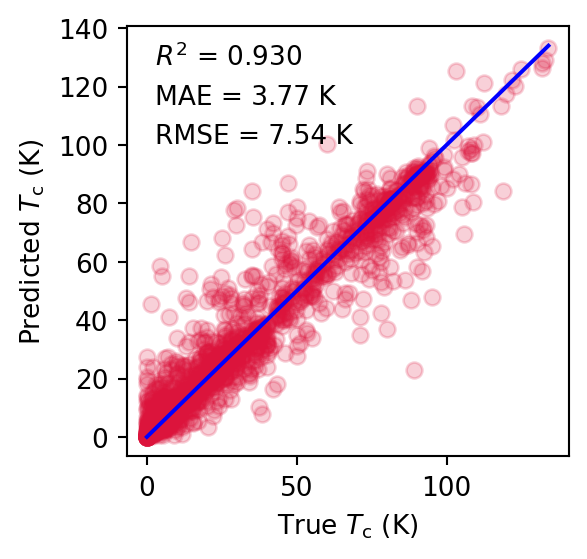

In [15]:
test_predictions = search.predict(test_df.iloc[:, :-1])
test_labels = test_df.iloc[:, -1].values


test_predictions = search.predict(
    test_df.iloc[:, :-1]
)  # Predicted y over samples of the testing set
test_labels = test_df.iloc[:, -1].values  # True y over samples of the testing set

r2 = sklearn.metrics.r2_score(
    test_labels, test_predictions
)  # coefficient of determination
mae = mean_absolute_error(test_labels, test_predictions)  # mean absolute error
rmse = np.sqrt(
    mean_squared_error(test_labels, test_predictions)
)  # root mean squared error

delta = max(test_labels) - min(test_labels)

import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3), dpi=190)
plt.scatter(test_labels, test_predictions, c="crimson", alpha=0.2)
p1 = max(max(test_predictions), max(test_labels))
p2 = min(min(test_predictions), min(test_labels))
plt.plot([p1, p2], [p1, p2], "b-")
plt.annotate(
    "$R^2$ = %0.3f" % r2,
    xy=(0.02 * delta, 0.95 * delta),
    xytext=(0.02 * delta, 0.95 * delta),
)
plt.annotate(
    "MAE = %0.2f K" % mae,
    xy=(0.02 * delta, 0.85 * delta),
    xytext=(0.02 * delta, 0.85 * delta),
)
plt.annotate(
    "RMSE = %0.2f K" % rmse,
    xy=(0.02 * delta, 0.75 * delta),
    xytext=(0.02 * delta, 0.75 * delta),
)
plt.xlabel("True $T_\mathrm{c}$ (K)")
plt.ylabel("Predicted $T_\mathrm{c}$ (K)")
plt.show()

In [16]:
search.best_params_

{'etr__max_features': 0.5,
 'etr__n_estimators': 500,
 'feature_selector__percentile': 100}

## Manual refitting

In [17]:
X_train = train_df.iloc[:, :-1].loc[:, VarianceThreshold(threshold = 0).fit(train_df.iloc[:, :-1]).get_support()]
X_test = test_df[X_train.columns]

In [18]:
correlated_features = set()  
corr_matrix = X_train.iloc[:, :-1].corr()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.9: # we are interested in absolute coeff value
            colname = corr_matrix.columns[i]  # getting the name of column
            correlated_features.add(colname)

In [19]:
X_train = X_train.drop(labels=correlated_features, axis=1)
X_test = X_test[X_train.columns]
y_train = train_df.iloc[:, -1]
y_test = test_df.iloc[:, -1]

In [20]:
X_train = X_train.loc[:, SelectPercentile(f_regression, percentile = 100).fit(X_train, y_train).get_support()]
X_test = X_test[X_train.columns]

In [21]:
etr = ExtraTreesRegressor(random_state=0, n_estimators = 500, max_features = 0.5)
etr.fit(X_train, y_train)

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features=0.5, max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=500, n_jobs=None, oob_score=False,
                    random_state=0, verbose=0, warm_start=False)

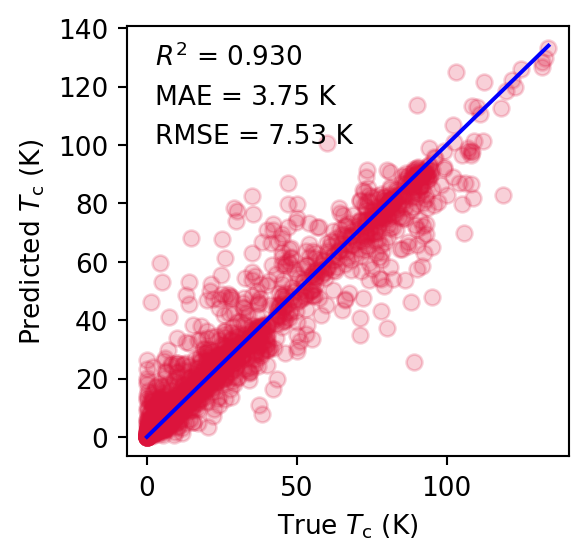

In [22]:
y_predictions = etr.predict(X_test)
r2 = sklearn.metrics.r2_score(y_test, y_predictions)
mae = mean_absolute_error(y_test, y_predictions)
rmse = np.sqrt(mean_squared_error(y_test, y_predictions))

import matplotlib.pyplot as plt

plt.figure(figsize=(3,3), dpi = 190)
plt.scatter(test_labels, y_predictions, c='crimson', alpha = 0.2)
p1 = max(max(y_predictions), max(y_test))
p2 = min(min(y_predictions), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
#plt.rc('xtick', labelsize=15)
#plt.rc('ytick', labelsize = 15)
plt.annotate(
    "$R^2$ = %0.3f" % r2,
    xy=(0.02 * delta, 0.95 * delta),
    xytext=(0.02 * delta, 0.95 * delta),
)
plt.annotate(
    "MAE = %0.2f K" % mae,
    xy=(0.02 * delta, 0.85 * delta),
    xytext=(0.02 * delta, 0.85 * delta),
)
plt.annotate(
    "RMSE = %0.2f K" % rmse,
    xy=(0.02 * delta, 0.75 * delta),
    xytext=(0.02 * delta, 0.75 * delta),
)
plt.xlabel("True $T_\mathrm{c}$ (K)")
plt.ylabel("Predicted $T_\mathrm{c}$ (K)")
plt.show()

In [23]:
import shap
explainer = shap.TreeExplainer(etr)
shap_values = explainer.shap_values(X_test)

In [24]:
X_test

,0-norm,2-norm,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,...,MagpieData mode GSbandgap,MagpieData minimum GSmagmom,MagpieData maximum GSmagmom,MagpieData mean GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData mean SpaceGroupNumber,compound possible,avg ionic char
Components,,,,,,,,,,,,,,,,,,,,,
Ba1000Ca500Cu1000O3979Tl1000,5.0,0.584081,8.0,81.0,73.0,27.788742,22.097546,8.0,7.0,87.0,...,0.000,0.0,0.000000,0.000000,0.0,12.0,229.0,108.068993,False,0.165637
As250Ba125Fe233Rh17,4.0,0.582855,26.0,56.0,30.0,35.316800,8.800046,33.0,9.0,84.0,...,0.000,0.0,2.110663,0.786855,0.0,166.0,229.0,203.691200,False,0.049114
B200C100Co14Lu100Ni193,5.0,0.514270,5.0,71.0,66.0,23.858320,18.311354,5.0,41.0,77.0,...,1.524,0.0,1.548471,0.225395,0.0,166.0,225.0,194.630972,False,0.031446
B40C20LaLu19Ni40,5.0,0.524537,5.0,71.0,66.0,23.716667,18.383333,5.0,13.0,77.0,...,0.000,0.0,0.595395,0.198821,0.0,166.0,225.0,195.000000,False,0.032198
Ba19Cu30LaO70Y10,5.0,0.608714,8.0,57.0,49.0,22.623077,15.747929,8.0,9.0,87.0,...,0.000,0.0,0.000000,0.000000,0.0,12.0,229.0,108.269231,False,0.161326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cu150La100O503Pb50Sr100,5.0,0.604543,8.0,82.0,74.0,24.334441,18.197616,8.0,8.0,87.0,...,0.000,0.0,0.000000,0.000000,0.0,12.0,225.0,102.919158,False,0.155326
Ba20CaCu40O80PrY8,6.0,0.613406,8.0,59.0,51.0,22.073333,15.039200,8.0,7.0,87.0,...,0.000,0.0,0.000000,0.000000,0.0,12.0,229.0,110.073333,False,0.156588
Mn42Si100V249,3.0,0.694622,14.0,25.0,11.0,20.913043,3.536084,23.0,46.0,78.0,...,0.000,0.0,0.000310,0.000033,0.0,217.0,229.0,227.199488,False,0.003879


In [26]:
Output_shap_mean = pd.read_excel('C:\\Users\\giovanni\\Desktop\\SHAP_ETR_ranking_superconductors.xlsx', index_col = 0)

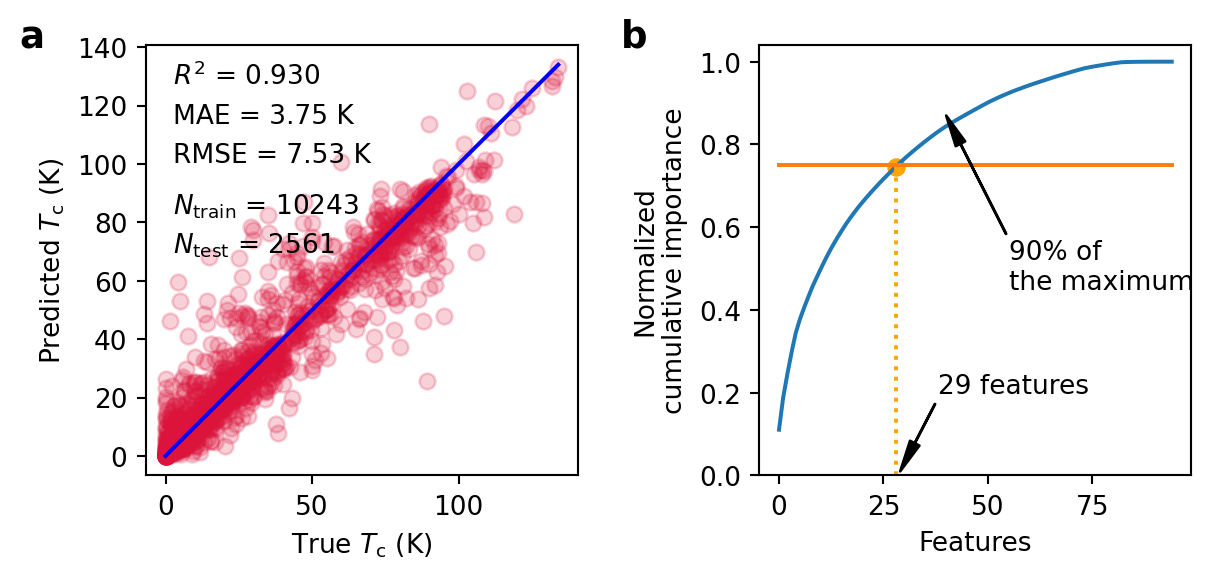

In [27]:
N = np.shape(X_test)[1]
k = 0.75
import matplotlib.pyplot as plt
cumsum = np.cumsum(np.sort(np.mean(abs(shap_values), axis = 0))[::-1])
normalized_cumulative = np.cumsum(np.sort(np.mean(abs(shap_values), axis = 0))[::-1])/(np.max(np.cumsum(np.sort(np.mean(abs(shap_values), axis = 0))[::-1])))
#normalized_cumulative = (np.cumsum(Output_shap_mean['mean']))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.1, 3), dpi = 190)                                                                                       
#fig, ax = plt.subplots(figsize=(3, 3), dpi = 190)


ax1.scatter(test_labels, y_predictions, c='crimson', alpha = 0.2)
p1 = max(max(y_predictions), max(y_test))
p2 = min(min(y_predictions), min(y_test))
ax1.plot([p1, p2], [p1, p2], 'b-')
#plt.rc('xtick', labelsize=15)
#plt.rc('ytick', labelsize = 15)
ax1.annotate(
    "$R^2$ = %0.3f" % r2,
    xy=(0.02 * delta, 0.95 * delta),
    xytext=(0.02 * delta, 0.95 * delta),
)
ax1.annotate(
    "MAE = %0.2f K" % mae,
    xy=(0.02 * delta, 0.85 * delta),
    xytext=(0.02 * delta, 0.85 * delta),
)
ax1.annotate(
    "RMSE = %0.2f K" % rmse,
    xy=(0.02 * delta, 0.75 * delta),
    xytext=(0.02 * delta, 0.75 * delta),
)

ax1.annotate(r'$N_{\rm{train}}$ = %0.0f' % len(train_df), xy=(0.02 * delta, 0.62 * delta), xytext=(0.02 * delta, 0.62 * delta),
            )
ax1.annotate(r'$N_{\rm{test}}$ = %0.0f' % len(test_df), xy=(0.02 * delta, 0.52 * delta), xytext=(0.02 * delta, 0.52 * delta),
            )

ax1.set_xlabel("True $T_\mathrm{c}$ (K)")
ax1.set_ylabel("Predicted $T_\mathrm{c}$ (K)")

ax1.annotate(
    r"$\mathbf{a}$",
    xy=(-4, 120),
    xytext=(-50, 140),
    fontsize = 14
)

ax1.annotate(
    r"$\mathbf{b}$",
    xy=(120, 120),
    xytext=(155, 140),
    fontsize = 14
)

ax2.plot(np.arange(N), normalized_cumulative)
ax2.plot(np.arange(N), k*np.ones(N))
ind_cross1 = np.argmin(np.fabs(normalized_cumulative-k*max(normalized_cumulative)*np.ones(N)))
#plt.yticks(np.array([0, 0.5, 1]))

ax2.annotate('%i features' %(ind_cross1+1), xy=(ind_cross1+1, .01), xytext=(ind_cross1+10,.2),
            arrowprops=dict(facecolor='black', shrink=0.000005, width = .1, headwidth=4),
            )
ax2.annotate('90% of\nthe maximum', xy=(40, 0.87), xytext=(55, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.0005, width = .1, headwidth=4),
            )
ax2.scatter(ind_cross1, normalized_cumulative[ind_cross1], color = 'orange')
ax2.plot((ind_cross1, ind_cross1), (normalized_cumulative[ind_cross1], 0), color = 'orange', ls = ':')
ax2.set_ylim(0, 1.04)
ax2.set_xlabel('Features')
ax2.set_ylabel('Normalized\ncumulative importance')

plt.subplots_adjust(wspace=0.42)


#plt.savefig('C:\\Users\\giovanni\\Desktop\\regression_supercon.pdf', bbox_inches = 'tight')
plt.show()

In [28]:
#Output_shap = pd.DataFrame(shap_values, index = X_test.index, columns = X_test.columns)
#Output_shap_mean = pd.DataFrame(abs(Output_shap).describe().loc['mean']/sum(abs(Output_shap).describe().loc['mean'])).sort_values('mean', ascending = False)

In [31]:
Output_shap_mean.to_excel('C:\\Users\\giovanni\\Desktop\\SHAP_ranking_superconductors.xlsx')

In [65]:
from joblib import dump, load
dump(search, 'ETR_supercon.joblib') 

['ETR_supercon.joblib']

## Validation #1

In [29]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

In [30]:
reduced_Data = Data[list(Output_shap_mean.index)[:29]]#Data.iloc[:, :-2]#[list(Output_shap_mean.index)]#Data.iloc[:, :-1]#

In [31]:
K = 20

silhouette_scores_agglo = np.zeros(K)

for i in tqdm.tqdm(range(K)):
    agglo = AgglomerativeClustering(n_clusters=2)
    labels_agglo = agglo.fit_predict(reduced_Data.iloc[:, :i+1])
    silhouette_scores_agglo[i] = silhouette_score(reduced_Data, labels_agglo)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:23<00:00,  7.16s/it]


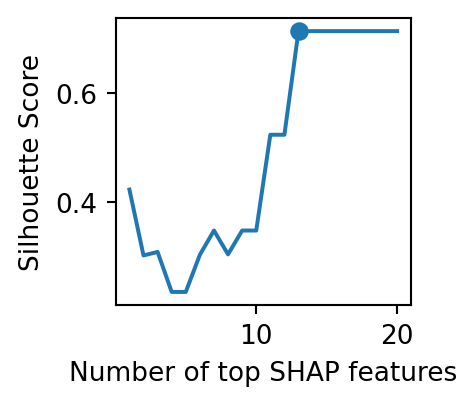

In [32]:
plt.figure(figsize=(2, 2), dpi=190)
plt.plot(range(1, K + 1), silhouette_scores_agglo)

# Scatter plot for the maximum Silhouette score
max_index = np.argmax(silhouette_scores_agglo) + 1
max_value = np.max(silhouette_scores_agglo)
plt.scatter(max_index, max_value)

# Labels
plt.xlabel('Number of top SHAP features')
plt.ylabel('Silhouette Score')
plt.show()


In [33]:
np.argmax(silhouette_scores_agglo)+1

13

In [34]:
agglo = AgglomerativeClustering(n_clusters=2)
labels_agglo = agglo.fit_predict(reduced_Data.iloc[:, :np.argmax(silhouette_scores_agglo)+1])
silhouette_score(reduced_Data, labels_agglo)

0.7133051339865168

In [35]:
reduced_Data[reduced_Data['Cluster'] == 1]

,avg ionic char,MagpieData mode Electronegativity,MagpieData maximum Electronegativity,MagpieData maximum GSvolume_pa,MagpieData mean NUnfilled,MagpieData range CovalentRadius,MagpieData minimum NUnfilled,MagpieData maximum GSmagmom,MagpieData avg_dev NdValence,MagpieData avg_dev NsUnfilled,...,MagpieData minimum Column,MagpieData maximum NpValence,MagpieData mean GSmagmom,MagpieData minimum MendeleevNumber,MagpieData mean SpaceGroupNumber,MagpieData maximum NValence,MagpieData minimum NValence,MagpieData maximum NsUnfilled,Tc,Cluster
Components,,,,,,,,,,,,,,,,,,,,,
H10La,0.021573,2.20,2.20,36.897500,1.727273,176.0,1.0,0.000000,0.165289,0.165289,...,1.0,0.0,0.000000,13.0,194.000000,3.0,1.0,1.0,250.0,1
H3S,0.006648,2.20,2.58,25.786875,1.250000,74.0,1.0,0.000000,0.000000,0.375000,...,1.0,4.0,0.000000,88.0,163.000000,6.0,1.0,1.0,147.0,1
Ba100Ca99Cu145Hg33O420Pb17,0.165437,3.44,3.44,63.590000,1.293612,149.0,0.0,0.000000,3.643397,0.292803,...,2.0,4.0,0.000000,7.0,113.197789,28.0,2.0,1.0,143.0,1
Ba1035Ca1035Cu1555Hg375O4104,0.167923,3.44,3.44,63.590000,1.204714,149.0,0.0,0.000000,3.628733,0.310125,...,2.0,4.0,0.000000,7.0,114.913993,26.0,2.0,1.0,135.8,1
Ba2070Ca2070Cu3110Hg750O8187,0.167961,3.44,3.44,63.590000,1.203682,149.0,0.0,0.000000,3.631968,0.310431,...,2.0,4.0,0.000000,7.0,115.047507,26.0,2.0,1.0,135.4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
As50F6Fe45Mn5O44Sm50,0.123487,1.17,3.98,33.230000,4.245000,141.0,1.0,2.110663,3.975000,0.000000,...,3.0,5.0,0.474907,23.0,143.040000,15.0,6.0,0.0,0.0,1
Cu98Fe2La185O400Sr15,0.165024,3.44,3.44,54.230000,3.672857,141.0,0.0,2.110663,2.353878,0.240800,...,2.0,4.0,0.006030,8.0,95.104286,11.0,2.0,1.0,0.0,1
Ce30Cu200Nd370O809,0.161532,3.44,3.44,37.240000,4.384670,138.0,1.0,0.000000,2.429883,0.243593,...,3.0,4.0,0.000000,15.0,93.902058,11.0,4.0,1.0,0.0,1


In [35]:
reduced_Data['Tc'] = Data['Tc']
reduced_Data['Cluster'] = labels_agglo

In [36]:
def add_randomness(df, level):
    n_change = int(len(df)*level)
    indices_to_change = np.random.choice(df.index, size=n_change, replace=False)
    new_classes = np.random.choice([0, 1], size=n_change)
    df_modified = df.copy()
    df_modified.loc[indices_to_change, 'Cluster'] = new_classes
    return df_modified

In [37]:
reduced_train_df, reduced_test_df = train_test_split(reduced_Data, test_size = 0.2, random_state = 0)

etc_valid_1 = ExtraTreesClassifier(random_state = 10)
etc_valid_1.fit(reduced_train_df.iloc[:, :-2], reduced_train_df.iloc[:, -1])

etr_valid_1 = ExtraTreesRegressor(random_state = 10)
train_df_cluster0 = reduced_train_df[reduced_train_df['Cluster'] == 0]
etr_valid_1.fit(train_df_cluster0.iloc[:, :-2], train_df_cluster0.iloc[:, -2])

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=10, verbose=0, warm_start=False)

In [38]:
L = 1000

AUC = np.zeros(L)
F1 = np.zeros(L)
r2_vector = np.zeros(L)
mae_vector = np.zeros(L)
rmse_vector = np.zeros(L)

reduced_train_df, reduced_test_df = train_test_split(reduced_Data, test_size = 0.2, random_state = 0)
n_rows = len(reduced_test_df)
n_cols = L
column_names = [i for i in range(n_cols)]

df_comparison_labels = pd.DataFrame(data=np.zeros((n_rows, n_cols)), columns=column_names)
df_comparison_labels.index = reduced_test_df.index
df_comparison_predictions = pd.DataFrame(data=np.zeros((n_rows, n_cols)), columns=column_names)
df_comparison_predictions.index = reduced_test_df.index


for i in tqdm.tqdm(range(L)):
    
    test_df_noised = add_randomness(reduced_test_df, i/L)
    
    
    test_predictions_c = etc_valid_1.predict(test_df_noised.iloc[:, :-2])
    test_labels_c = test_df_noised.iloc[:, -1].values
    test_proba_predictions = etc_valid_1.predict_proba(test_df_noised.iloc[:, :-2]) 
    fpr, tpr, thresholds = roc_curve(test_labels_c, test_proba_predictions.transpose()[1]) 
    F1[i] = f1_score(test_labels_c, test_predictions_c)
    AUC[i] = roc_auc_score(test_df_noised['Cluster'], test_proba_predictions.transpose()[1])
    
    
    test_for_comparison = test_df_noised.copy()
    test_for_comparison['Tc_predicted'] = etr_valid_1.predict(test_df_noised.iloc[:, :-2])
    
    test_predictions_r = test_for_comparison[test_for_comparison['Cluster'] == 0]['Tc_predicted']
    test_labels_r = test_for_comparison[test_for_comparison['Cluster'] == 0]['Tc']
    
    df_comparison_predictions[i] = test_predictions_r
    df_comparison_labels[i] = test_labels_r
    
    r2_vector[i] = sklearn.metrics.r2_score(test_labels_r, test_predictions_r)
    mae_vector[i] = mean_absolute_error(test_labels_r, test_predictions_r)  
    rmse_vector[i] = np.sqrt(mean_squared_error(test_labels_r, test_predictions_r))  

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:41<00:00,  9.85it/s]


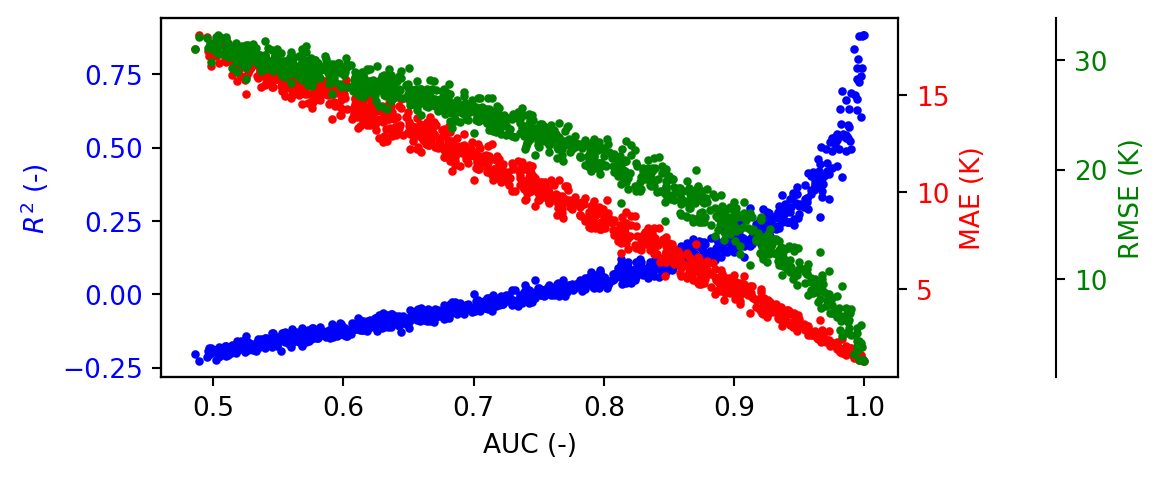

In [39]:
import matplotlib.pyplot as plt

# Create a figure and an initial axis
fig, ax1 = plt.subplots(figsize=(5, 2.5), dpi=190)

# First scatter plot for R^2
ax1.scatter(AUC, r2_vector, s=5, color='b', label='$R^2$')
ax1.set_xlabel('AUC (-)')
ax1.set_ylabel('$R^2$ (-)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for MAE
ax2 = ax1.twinx()
ax2.scatter(AUC, mae_vector, s=5, color='r', label='MAE (K)')
ax2.set_ylabel('MAE (K)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Create a third y-axis for RMSE
ax3 = ax1.twinx()

# Offset the third y-axis to avoid overlap
ax3.spines['right'].set_position(('outward', 60))  # Move it 60 points away from ax2
ax3.scatter(AUC, rmse_vector, s=5, color='g', label='RMSE (K)')
ax3.set_ylabel('RMSE (K)', color='g')
ax3.tick_params(axis='y', labelcolor='g')

plt.show()



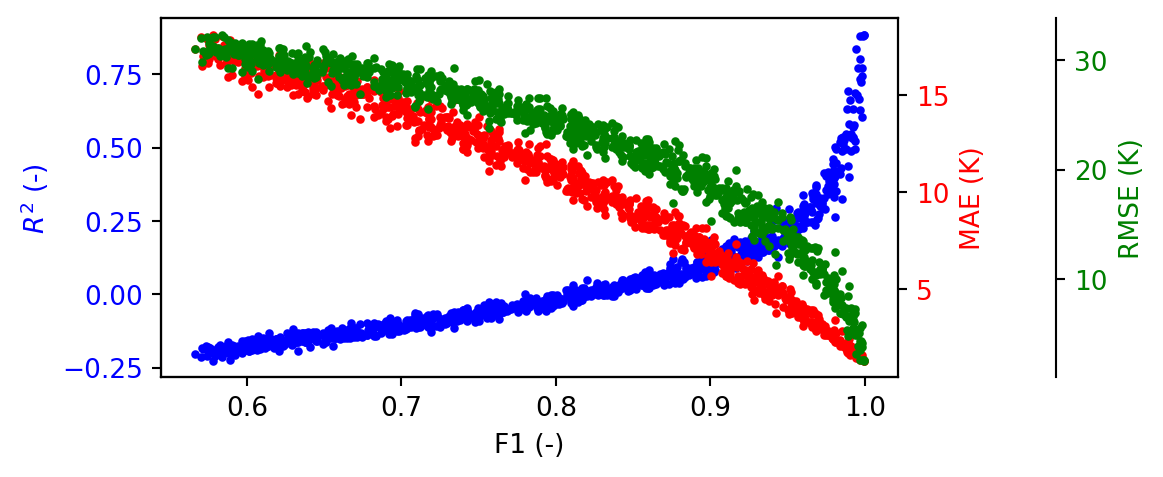

In [40]:
import matplotlib.pyplot as plt

# Create a figure and an initial axis
fig, ax1 = plt.subplots(figsize=(5, 2.5), dpi=190)

# First scatter plot for R^2
ax1.scatter(F1, r2_vector, s=5, color='b', label='$R^2$')
ax1.set_xlabel('F1 (-)')
ax1.set_ylabel('$R^2$ (-)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for MAE
ax2 = ax1.twinx()
ax2.scatter(F1, mae_vector, s=5, color='r', label='MAE (K)')
ax2.set_ylabel('MAE (K)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Create a third y-axis for RMSE
ax3 = ax1.twinx()

# Offset the third y-axis to avoid overlap
ax3.spines['right'].set_position(('outward', 60))  # Move it 60 points away from ax2
ax3.scatter(F1, rmse_vector, s=5, color='g', label='RMSE (K)')
ax3.set_ylabel('RMSE (K)', color='g')
ax3.tick_params(axis='y', labelcolor='g')

# Add a legend to distinguish between the different data series
#fig.legend(loc="center", bbox_to_anchor=(0.68, 0.75), frameon = False)#, bbox_transform=ax1.transAxes)

plt.show()

## Validation 2

In [41]:
#MPj creation
MPj = pd.read_excel('mats_from_MPj.xlsx', index_col = 0)
MPj = MPj.rename(columns={"pretty_formula": "Components"})
MPj = MPj.dropna()

normalizer = MaterialsTextProcessor()
for i in tqdm.tqdm(range(len(MPj))):
    MPj['Components'].iloc[i] = normalizer.normalized_formula(MPj['Components'].iloc[i])
    
MPj = MPj[['Components']].drop_duplicates()

100%|█████████████████████████████████████████████████████████████████████████| 154715/154715 [06:48<00:00, 378.88it/s]


In [42]:
MPj = featurizing(MPj)

MultipleFeaturizer:   0%|          | 0/105582 [00:00<?, ?it/s]

In [43]:
MPj = MPj[list(Output_shap_mean.index)[:29]]

In [44]:
Cluster_1 = reduced_Data[reduced_Data['Cluster'] == 1]
Cluster_0 = reduced_Data[reduced_Data['Cluster'] == 0]

In [45]:
Cluster_0_regr = Cluster_0.sample(frac = 0.5, random_state = 0)

In [46]:
Cluster_0_regr

,avg ionic char,MagpieData mode Electronegativity,MagpieData maximum Electronegativity,MagpieData maximum GSvolume_pa,MagpieData mean NUnfilled,MagpieData range CovalentRadius,MagpieData minimum NUnfilled,MagpieData maximum GSmagmom,MagpieData avg_dev NdValence,MagpieData avg_dev NsUnfilled,...,MagpieData minimum Column,MagpieData maximum NpValence,MagpieData mean GSmagmom,MagpieData minimum MendeleevNumber,MagpieData mean SpaceGroupNumber,MagpieData maximum NValence,MagpieData minimum NValence,MagpieData maximum NsUnfilled,Tc,Cluster
Components,,,,,,,,,,,,,,,,,,,,,
B2Ta,0.015624,2.04,2.04,18.120,5.666667,86.0,5.0,0.000000,1.333333,0.000000,...,5.0,1.0,0.000000,48.0,187.000000,19.0,3.0,0.0,9.50,0
Hf5PdRh4Si5,0.036285,1.30,2.28,22.200,4.800000,64.0,0.0,0.000000,3.288889,0.391111,...,4.0,2.0,0.000000,45.0,215.333333,18.0,4.0,1.0,1.85,0
C50Re3W50,0.004263,2.36,2.55,16.050,5.000000,86.0,4.0,0.000000,2.026581,0.000000,...,6.0,2.0,0.000000,51.0,210.990291,21.0,4.0,0.0,5.00,0
Nb83Sb17,0.006965,1.60,2.05,31.560,6.320000,25.0,3.0,0.000000,1.693200,0.282200,...,5.0,3.0,0.000000,47.0,218.290000,15.0,5.0,1.0,1.95,0
Co11Mo14,0.004782,2.16,2.16,15.690,4.680000,28.0,3.0,1.548471,0.985600,0.492800,...,6.0,0.0,0.681327,50.0,213.600000,9.0,6.0,1.0,13.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
As1000Ba500Co22Cu19Fe959,0.047929,2.18,2.18,63.590,2.768400,96.0,0.0,2.110663,2.912634,0.015084,...,2.0,3.0,0.823277,9.0,203.461600,15.0,2.0,1.0,8.70,0
Nb5Ti14V,0.000231,1.54,1.63,18.180,7.700000,11.0,7.0,0.000023,0.770000,0.375000,...,4.0,0.0,0.000016,43.0,204.500000,5.0,4.0,1.0,7.70,0
B625Mo288Zr12,0.002433,2.04,2.16,23.195,5.350270,91.0,5.0,0.000000,2.138787,0.428823,...,4.0,1.0,0.000000,44.0,185.978378,6.0,3.0,1.0,7.51,0


In [47]:
train_df_2, test_df_2 = train_test_split(Cluster_0_regr, test_size = 0.2, random_state = 0)
etr_valid_2 = ExtraTreesRegressor(random_state = 1)
etr_valid_2.fit(train_df_2.iloc[:, :-2], train_df_2.iloc[:, -2])

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=1, verbose=0, warm_start=False)

In [48]:
MPj = MPj.reset_index()
MPj['is_in_regr_0'] = 0
for i in tqdm.tqdm(range(len(MPj))):
    if MPj['Components'].iloc[i] in list(Cluster_0_regr.index):
        MPj['is_in_regr_0'].iloc[i] = 1
MPj = MPj.set_index('Components')

100%|████████████████████████████████████████████████████████████████████████| 105582/105582 [00:18<00:00, 5845.31it/s]


In [49]:
MPj_no_regr_0 = MPj[MPj['is_in_regr_0'] == 0].dropna()
Cluster_0_regr = Cluster_0_regr.iloc[:, :-2]
Cluster_0_regr['is_in_regr_0'] = 1

In [50]:
import random
idxs_random = random.sample(set(MPj_no_regr_0.index), 
                                   len(Cluster_0_regr))

MPj_no_regr_0_subset = MPj_no_regr_0.loc[idxs_random]
df_valid_2 = pd.concat([Cluster_0_regr, MPj_no_regr_0_subset])

In [52]:
df_valid_2

,avg ionic char,MagpieData mode Electronegativity,MagpieData maximum Electronegativity,MagpieData maximum GSvolume_pa,MagpieData mean NUnfilled,MagpieData range CovalentRadius,MagpieData minimum NUnfilled,MagpieData maximum GSmagmom,MagpieData avg_dev NdValence,MagpieData avg_dev NsUnfilled,...,MagpieData mean NsValence,MagpieData minimum Column,MagpieData maximum NpValence,MagpieData mean GSmagmom,MagpieData minimum MendeleevNumber,MagpieData mean SpaceGroupNumber,MagpieData maximum NValence,MagpieData minimum NValence,MagpieData maximum NsUnfilled,is_in_regr_0
Components,,,,,,,,,,,,,,,,,,,,,
B2Ta,0.015624,2.04,2.04,18.120,5.666667,86.0,5.0,0.000000,1.333333,0.000000,...,2.000000,5.0,1.0,0.000000,48.0,187.000000,19.0,3.0,0.0,1
Hf5PdRh4Si5,0.036285,1.30,2.28,22.200,4.800000,64.0,0.0,0.000000,3.288889,0.391111,...,1.600000,4.0,2.0,0.000000,45.0,215.333333,18.0,4.0,1.0,1
C50Re3W50,0.004263,2.36,2.55,16.050,5.000000,86.0,4.0,0.000000,2.026581,0.000000,...,2.000000,6.0,2.0,0.000000,51.0,210.990291,21.0,4.0,0.0,1
Nb83Sb17,0.006965,1.60,2.05,31.560,6.320000,25.0,3.0,0.000000,1.693200,0.282200,...,1.170000,5.0,3.0,0.000000,47.0,218.290000,15.0,5.0,1.0,1
Co11Mo14,0.004782,2.16,2.16,15.690,4.680000,28.0,3.0,1.548471,0.985600,0.492800,...,1.440000,6.0,0.0,0.681327,50.0,213.600000,9.0,6.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Er2O7Sb2,0.130525,3.44,3.44,31.560,2.181818,123.0,2.0,0.000000,2.975207,0.000000,...,2.000000,3.0,4.0,0.000000,35.0,73.090909,15.0,6.0,0.0,0
CoGe3Sm,0.024648,2.01,2.01,33.230,4.600000,78.0,3.0,1.548471,3.120000,0.000000,...,2.000000,3.0,2.0,0.309694,23.0,207.000000,14.0,8.0,0.0,0
BCsMg30O32,0.169943,3.44,3.44,115.765,1.093750,178.0,0.0,0.000000,0.000000,0.030762,...,1.984375,1.0,4.0,0.000000,5.0,103.109375,6.0,1.0,1.0,0


In [53]:
import random

In [54]:
model_2_validation = {}

for j in tqdm.tqdm(range(10)):

    seed_value = j
    random.seed(seed_value+10)
    idxs_random = random.sample(set(MPj_no_regr_0.index), 
                                       len(Cluster_0_regr))

    MPj_no_regr_0_subset = MPj_no_regr_0.loc[idxs_random]
    df_valid_2 = pd.concat([Cluster_0_regr, MPj_no_regr_0_subset])
    
    df_valid_2 = df_valid_2.dropna()
    #df[['is_in_SuperCon']].to_excel('C:\\Users\\giovanni\\Desktop\\is_in_SuperCon\\is_in_SuperCon_%0.0f.xlsx' % j)
    train_df_valid_2, test_df_valid_2 = train_test_split(df_valid_2, test_size = 0.2, random_state = 0)
    
    model_valid_2 = ExtraTreesClassifier(random_state = 0)
    model_valid_2.fit(train_df_valid_2.iloc[:, :-1], train_df_valid_2.iloc[:, -1])
    
    test_predictions_valid_2 = model_valid_2.predict(test_df_valid_2.iloc[:, :-1]) 
    test_labels_valid_2 = test_df_valid_2.iloc[:, -1].values
    test_proba_predictions_valid_2 = model_valid_2.predict_proba(test_df_valid_2.iloc[:, :-1]) 
    fpr1, tpr1, thresholds1 = roc_curve(test_labels_valid_2, test_proba_predictions_valid_2.transpose()[1]) 

    print('F1 =', f1_score(test_labels_valid_2, test_predictions_valid_2), 
         'AUC =', roc_auc_score(test_df_valid_2['is_in_regr_0'], test_proba_predictions_valid_2.transpose()[1]))
    
    model_2_validation[f'model_valid_2_{j}'] = model_valid_2    
    #dump(model_2_validation[f'model_valid_2_{i}'], 'classifier_verification_again_%0.0f.joblib' % j)

 10%|████████▎                                                                          | 1/10 [00:00<00:02,  3.21it/s]

F1 = 0.9569495694956949 AUC = 0.9912154578821246


 20%|████████████████▌                                                                  | 2/10 [00:00<00:02,  3.27it/s]

F1 = 0.9516908212560385 AUC = 0.9905056571723239


 30%|████████████████████████▉                                                          | 3/10 [00:00<00:02,  3.17it/s]

F1 = 0.9362214199759327 AUC = 0.9832438499105166


 40%|█████████████████████████████████▏                                                 | 4/10 [00:01<00:01,  3.21it/s]

F1 = 0.9439809296781883 AUC = 0.9901295234628569


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:01<00:01,  3.22it/s]

F1 = 0.9636803874092009 AUC = 0.9931476931476931


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:01<00:01,  3.19it/s]

F1 = 0.9417475728155339 AUC = 0.9888706888706889


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:02<00:00,  3.08it/s]

F1 = 0.9598051157125457 AUC = 0.9917250583917251


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:02<00:00,  3.03it/s]

F1 = 0.9317365269461076 AUC = 0.9859071192404526


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:02<00:00,  3.08it/s]

F1 = 0.9464720194647201 AUC = 0.9889465222798556


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.14it/s]

F1 = 0.936678614097969 AUC = 0.9846968180301514


In [56]:
complete_test_df = pd.concat([Cluster_0.drop(Cluster_0_regr.index), Cluster_1])

In [57]:
for i in tqdm.tqdm(range(10)):

    probs_out = pd.DataFrame(model_2_validation[f'model_valid_2_{i}'].predict_proba(complete_test_df.iloc[:, :-2-i]), 
                 index = complete_test_df.index)

    complete_test_df[f'prob. classifier_{i}'] = probs_out[1]


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.52it/s]


In [58]:
complete_test_df.iloc[:, 31:]

,prob. classifier_0,prob. classifier_1,prob. classifier_2,prob. classifier_3,prob. classifier_4,prob. classifier_5,prob. classifier_6,prob. classifier_7,prob. classifier_8,prob. classifier_9
Components,,,,,,,,,,
Al8Fe4Yb,0.15,0.25,0.23,0.40,0.22,0.29,0.31,0.32,0.27,0.26
As2000Ca891Fe2000La109,1.00,0.99,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
As45Ca42Fe50Nd8Sb5,0.97,0.99,1.00,0.98,1.00,0.99,0.99,0.99,0.98,0.98
As400Ca167Fe400La33,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
B20Be3Mg7,1.00,1.00,1.00,0.98,1.00,1.00,1.00,1.00,1.00,1.00
...,...,...,...,...,...,...,...,...,...,...
As50F6Fe45Mn5O44Sm50,0.01,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.00,0.00
Cu98Fe2La185O400Sr15,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Ce30Cu200Nd370O809,0.00,0.01,0.01,0.00,0.00,0.01,0.00,0.00,0.00,0.00


In [59]:
complete_test_df['avg_probability'] = np.mean(complete_test_df.iloc[:, 31:], axis = 1)
complete_test_df['std_probability'] = np.std(complete_test_df.iloc[:, 31:-1], axis = 1)

In [60]:
complete_test_df.iloc[:, :-14]

,avg ionic char,MagpieData mode Electronegativity,MagpieData maximum Electronegativity,MagpieData maximum GSvolume_pa,MagpieData mean NUnfilled,MagpieData range CovalentRadius,MagpieData minimum NUnfilled,MagpieData maximum GSmagmom,MagpieData avg_dev NdValence,MagpieData avg_dev NsUnfilled,...,MagpieData maximum CovalentRadius,MagpieData mean NsValence,MagpieData minimum Column,MagpieData maximum NpValence,MagpieData mean GSmagmom,MagpieData minimum MendeleevNumber,MagpieData mean SpaceGroupNumber,MagpieData maximum NValence,MagpieData minimum NValence,MagpieData maximum NsUnfilled
Components,,,,,,,,,,,,,,,,,,,,,
Al8Fe4Yb,0.008210,1.61,1.83,34.1200,4.307692,66.0,0.0,2.110663,2.556213,0.000000,...,187.0,2.000000,3.0,1.0,0.649435,39.0,226.230769,16.0,3.0,0.0
As2000Ca891Fe2000La109,0.040360,1.83,2.18,37.7700,2.996200,88.0,0.0,2.110663,2.862560,0.000000,...,207.0,2.000000,2.0,3.0,0.844265,7.0,202.324200,15.0,2.0,0.0
As45Ca42Fe50Nd8Sb5,0.051091,1.83,2.18,37.7700,2.866667,82.0,0.0,2.110663,3.555556,0.000000,...,201.0,2.000000,2.0,3.0,0.703554,7.0,205.013333,15.0,2.0,0.0
As400Ca167Fe400La33,0.040030,1.83,2.18,37.7700,3.097000,88.0,0.0,2.110663,2.853600,0.000000,...,207.0,2.000000,2.0,3.0,0.844265,7.0,201.977000,15.0,2.0,0.0
B20Be3Mg7,0.023376,2.04,2.04,22.8900,3.333333,57.0,0.0,0.000000,0.000000,0.000000,...,141.0,2.000000,2.0,1.0,0.000000,67.0,175.333333,3.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
As50F6Fe45Mn5O44Sm50,0.123487,1.17,3.98,33.2300,4.245000,141.0,1.0,2.110663,3.975000,0.000000,...,198.0,2.000000,3.0,5.0,0.474907,23.0,143.040000,15.0,6.0,0.0
Cu98Fe2La185O400Sr15,0.165024,3.44,3.44,54.2300,3.672857,141.0,0.0,2.110663,2.353878,0.240800,...,207.0,1.860000,2.0,4.0,0.006030,8.0,95.104286,11.0,2.0,1.0
Ce30Cu200Nd370O809,0.161532,3.44,3.44,37.2400,4.384670,138.0,1.0,0.000000,2.429883,0.243593,...,204.0,1.858055,3.0,4.0,0.000000,15.0,93.902058,11.0,4.0,1.0


In [61]:
complete_test_df['Tc_predicted'] = etr_valid_2.predict(complete_test_df.iloc[:, :-14])
reduced = complete_test_df[['Tc', 'Tc_predicted', 'avg_probability', 'std_probability']]

In [62]:
p_threshold = np.arange(0, 1, 1e-3)
r2_vector_valid_2 = np.zeros(len(p_threshold))
mae_vector_valid_2 = np.zeros(len(p_threshold))
rmse_vector_valid_2 = np.zeros(len(p_threshold))

for i in tqdm.tqdm(range(len(p_threshold))):
    df_modified = reduced.copy()
    df_modified = df_modified[df_modified['avg_probability'] > p_threshold[i]]
    
    r2_vector_valid_2[i] = sklearn.metrics.r2_score(df_modified['Tc'], df_modified['Tc_predicted'])
    mae_vector_valid_2[i] = mean_absolute_error(df_modified['Tc'], df_modified['Tc_predicted'])
    rmse_vector_valid_2[i] = np.sqrt(mean_squared_error(df_modified['Tc'], df_modified['Tc_predicted']))
    
    

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 759.86it/s]


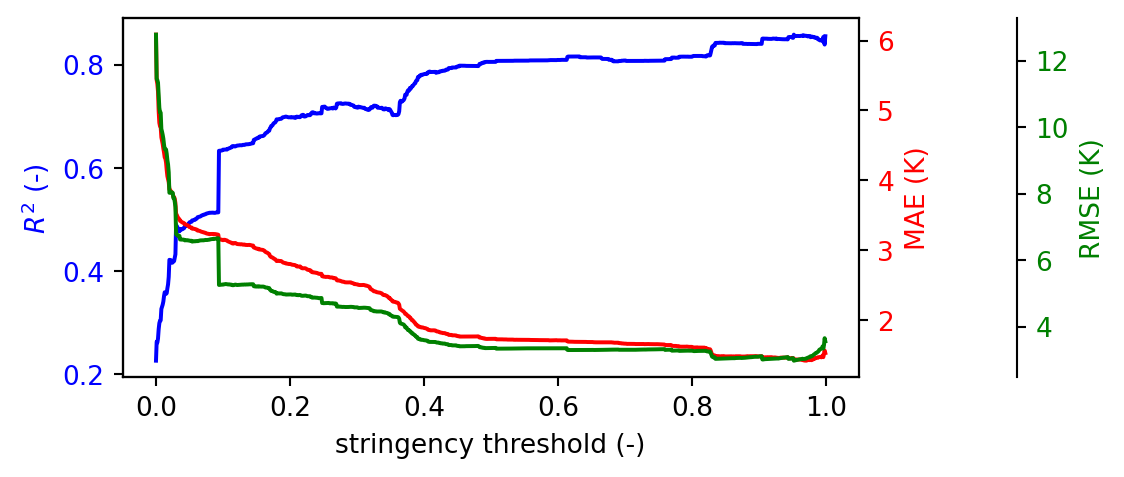

In [63]:
import matplotlib.pyplot as plt

# Create a figure and an initial axis
fig, ax1 = plt.subplots(figsize=(5, 2.5), dpi=190)

# First scatter plot for R^2
ax1.plot(p_threshold, r2_vector_valid_2, color='b', label='$R^2$')
ax1.set_xlabel('stringency threshold (-)')
ax1.set_ylabel('$R^2$ (-)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for MAE
ax2 = ax1.twinx()
ax2.plot(p_threshold, mae_vector_valid_2, color='r', label='MAE (K)')
ax2.set_ylabel('MAE (K)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Create a third y-axis for RMSE
ax3 = ax1.twinx()

# Offset the third y-axis to avoid overlap
ax3.spines['right'].set_position(('outward', 60))  # Move it 60 points away from ax2
ax3.plot(p_threshold, rmse_vector_valid_2, color='g', label='RMSE (K)')
ax3.set_ylabel('RMSE (K)', color='g')
ax3.tick_params(axis='y', labelcolor='g')

# Add a legend to distinguish between the different data series
#fig.legend(loc="center", bbox_to_anchor=(0.68, 0.75), frameon = False)#, bbox_transform=ax1.transAxes)

plt.show()

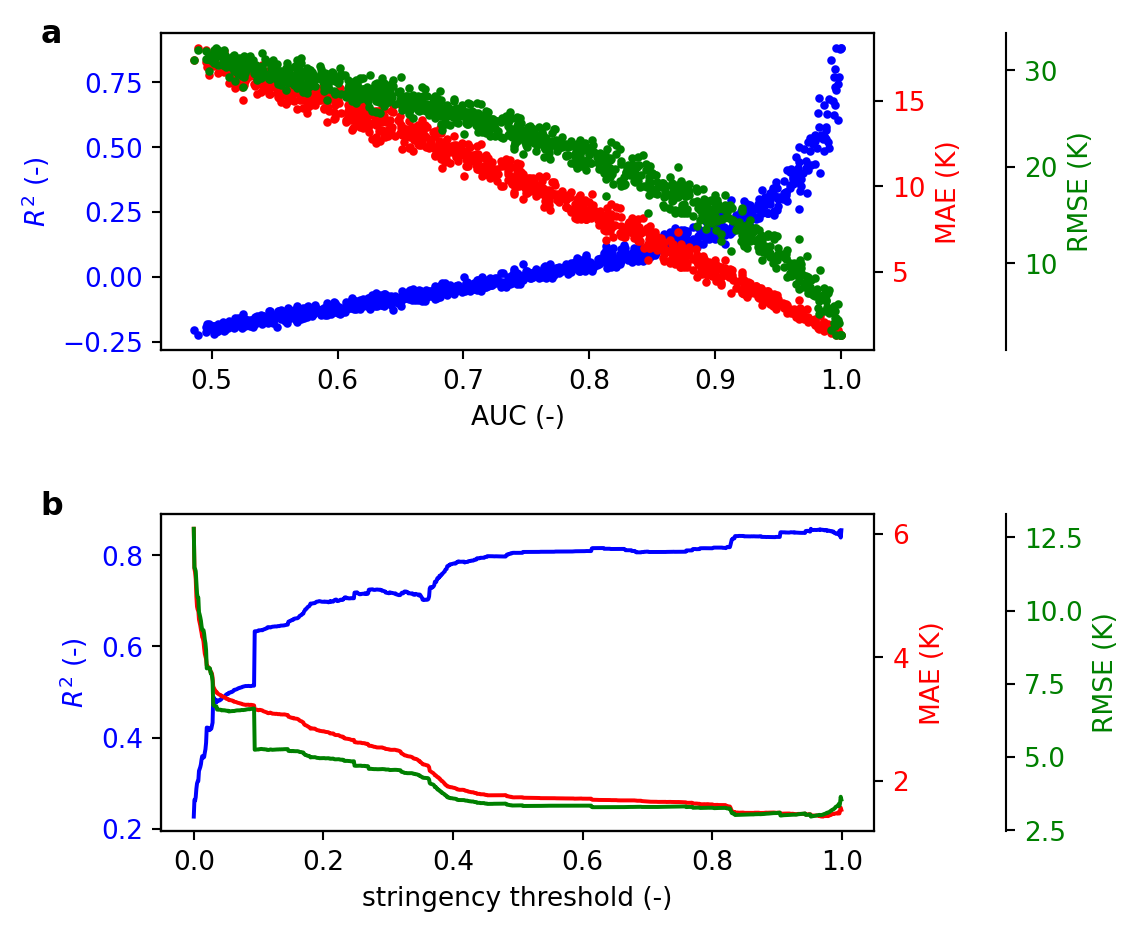

In [64]:
import matplotlib.pyplot as plt

# Create a figure with two subplots, vertically stacked
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 5), dpi=190)

# --- First subplot (top): scatter plots ---

# First scatter plot for R^2
ax1.scatter(AUC, r2_vector, s=5, color='b', label='$R^2$')
ax1.set_xlabel('AUC (-)')
ax1.set_ylabel('$R^2$ (-)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for MAE
ax1_twin2 = ax1.twinx()
ax1_twin2.scatter(AUC, mae_vector, s=5, color='r', label='MAE (K)')
ax1_twin2.set_ylabel('MAE (K)', color='r')
ax1_twin2.tick_params(axis='y', labelcolor='r')

# Create a third y-axis for RMSE
ax1_twin3 = ax1.twinx()

# Offset the third y-axis to avoid overlap
ax1_twin3.spines['right'].set_position(('outward', 50))  # Move it 60 points away from ax2
ax1_twin3.scatter(AUC, rmse_vector, s=5, color='g', label='RMSE (K)')
ax1_twin3.set_ylabel('RMSE (K)', color='g')
ax1_twin3.tick_params(axis='y', labelcolor='g')

# Annotate subplot (a)
ax1.annotate('a', xy=(-.17, .97), xycoords='axes fraction', fontsize=12, fontweight='bold')



# --- Second subplot (bottom): line plots ---

# First line plot for R^2
ax2.plot(p_threshold, r2_vector_valid_2, color='b', label='$R^2$')
ax2.set_xlabel('stringency threshold (-)')
ax2.set_ylabel('$R^2$ (-)', color='b')
ax2.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for MAE
ax2_twin2 = ax2.twinx()
ax2_twin2.plot(p_threshold, mae_vector_valid_2, color='r', label='MAE (K)')
ax2_twin2.set_ylabel('MAE (K)', color='r')
ax2_twin2.tick_params(axis='y', labelcolor='r')

# Create a third y-axis for RMSE
ax2_twin3 = ax2.twinx()

# Offset the third y-axis to avoid overlap
ax2_twin3.spines['right'].set_position(('outward', 50))  # Move it 60 points away from ax2_twin2
ax2_twin3.plot(p_threshold, rmse_vector_valid_2, color='g', label='RMSE (K)')
ax2_twin3.set_ylabel('RMSE (K)', color='g')
ax2_twin3.tick_params(axis='y', labelcolor='g')

# Annotate subplot (b)
ax2.annotate('b', xy=(-.17, 1), xycoords='axes fraction', fontsize=12, fontweight='bold')

# Adjust layout to avoid overlap
plt.tight_layout()

plt.subplots_adjust(hspace=.52)

#plt.savefig('C:\\Users\\giovanni\\Desktop\\validation_superconductors.pdf', bbox_inches = 'tight')

plt.show()


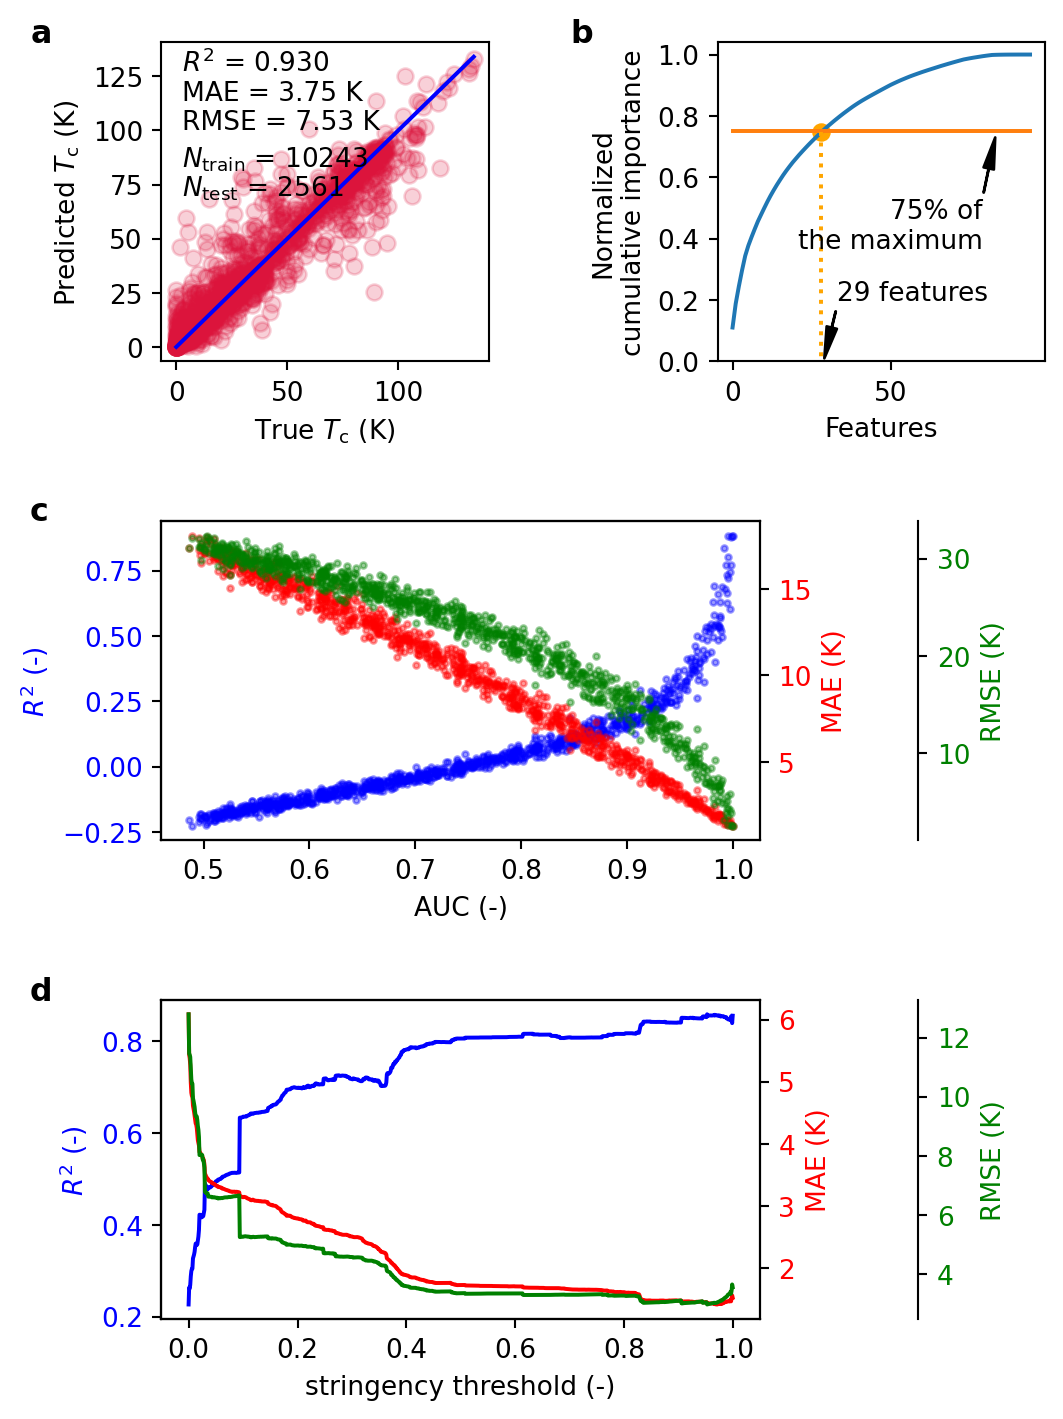

In [66]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming these variables are already defined in your environment:
# X_test, shap_values, test_labels, y_predictions, y_test, r2, mae, rmse, train_df, test_df
# AUC, r2_vector, mae_vector, rmse_vector, p_threshold, r2_vector_valid_2, mae_vector_valid_2, rmse_vector_valid_2

# Precompute values for the first plot
N = np.shape(X_test)[1]
k = 0.75
#cumsum = np.cumsum(np.sort(np.mean(abs(shap_values), axis=0))[::-1])
#normalized_cumulative = cumsum / np.max(cumsum)
ind_cross1 = np.argmin(np.fabs(normalized_cumulative - k * np.ones(N)))

# Create a figure with constrained layout to include outward axes within the figure size
fig = plt.figure(figsize=(6, 8.9), dpi=190)  # Use constrained_layout=True
gs = fig.add_gridspec(3, 3)  # 3 rows, 2 columns

# --- First plot: scatter plot (ax1 in the original code) ---
ax1 = fig.add_subplot(gs[0, 0])  # Top-left
ax1.scatter(test_labels, y_predictions, c='crimson', alpha=0.2)
p1 = max(max(y_predictions), max(y_test))
p2 = min(min(y_predictions), min(y_test))
ax1.plot([p1, p2], [p1, p2], 'b-')
ax1.annotate("$R^2$ = %0.3f" % r2, xy=(0.02 * (p1 - p2), 0.95 * (p1 - p2)), xytext=(0.02 * (p1 - p2), 0.95 * (p1 - p2)))
ax1.annotate("MAE = %0.2f K" % mae, xy=(0.02 * (p1 - p2), 0.85 * (p1 - p2)), xytext=(0.02 * (p1 - p2), 0.85 * (p1 - p2)))
ax1.annotate("RMSE = %0.2f K" % rmse, xy=(0.02 * (p1 - p2), 0.75 * (p1 - p2)), xytext=(0.02 * (p1 - p2), 0.75 * (p1 - p2)))
ax1.annotate(r'$N_{\rm{train}}$ = %0.0f' % len(train_df), xy=(0.02 * (p1 - p2), 0.62 * (p1 - p2)), xytext=(0.02 * (p1 - p2), 0.62 * (p1 - p2)))
ax1.annotate(r'$N_{\rm{test}}$ = %0.0f' % len(test_df), xy=(0.02 * (p1 - p2), 0.52 * (p1 - p2)), xytext=(0.02 * (p1 - p2), 0.52 * (p1 - p2)))
ax1.set_xlabel("True $T_{\mathrm{c}}$ (K)")
ax1.set_ylabel("Predicted $T_{\mathrm{c}}$ (K)")
ax1.annotate('a', xy=(-.4, 1), xycoords='axes fraction', fontsize=12, fontweight='bold')

# --- Second plot: cumulative importance (ax2 in the original code) ---
ax2 = fig.add_subplot(gs[0, 2])  # Top-right
ax2.plot(np.arange(N), normalized_cumulative)
ax2.plot(np.arange(N), k * np.ones(N))
ax2.annotate('%i features' % (ind_cross1 + 1), xy=(ind_cross1 + 1, .01), xytext=(ind_cross1 + 5, .2), arrowprops=dict(facecolor='black', shrink=0.000005, width=.1, headwidth=4))
ax2.annotate('75% of\nthe maximum', ha='right', xy=(83, 0.73), xytext=(79, 0.37), arrowprops=dict(facecolor='black', shrink=0.0005, width=.1, headwidth=4))
ax2.scatter(ind_cross1, normalized_cumulative[ind_cross1], color='orange')
ax2.plot((ind_cross1, ind_cross1), (normalized_cumulative[ind_cross1], 0), color='orange', ls=':')
ax2.set_ylim(0, 1.04)
ax2.set_xlabel('Features')
ax2.set_ylabel('Normalized\ncumulative importance')
ax2.annotate('b', xy=(-.45, 1), xycoords='axes fraction', fontsize=12, fontweight='bold')

# --- Third plot: scatter plots (ax3 in the new code) ---
gs = fig.add_gridspec(3, 2)  # 3 rows, 2 columns
gs.update(right=0.65)
ax3 = fig.add_subplot(gs[1, :])  # Second row, spanning both columns
ax3.scatter(AUC, r2_vector, s=5, color='b', label='$R^2$', alpha=0.4)
ax3.set_xlabel('AUC (-)')
ax3.set_ylabel('$R^2$ (-)', color='b')
ax3.tick_params(axis='y', labelcolor='b')

# Create second y-axis for MAE
ax3_twin2 = ax3.twinx()
ax3_twin2.scatter(AUC, mae_vector, s=5, color='r', label='MAE (K)', alpha=0.4)
ax3_twin2.set_ylabel('MAE (K)', color='r')
ax3_twin2.tick_params(axis='y', labelcolor='r')

# Create third y-axis for RMSE
ax3_twin3 = ax3.twinx()
ax3_twin3.spines['right'].set_position(('outward', 60))
ax3_twin3.scatter(AUC, rmse_vector, s=5, color='g', label='RMSE (K)', alpha=0.4)
ax3_twin3.set_ylabel('RMSE (K)', color='g')
ax3_twin3.tick_params(axis='y', labelcolor='g')

# Annotate subplot (c)
ax3.annotate('c', xy=(-.22, 1.001), xycoords='axes fraction', fontsize=12, fontweight='bold')

# --- Fourth plot: line plots (ax4 in the new code) ---
ax4 = fig.add_subplot(gs[2, :])  # Third row, spanning both columns
ax4.plot(p_threshold, r2_vector_valid_2, color='b', label='$R^2$')
ax4.set_xlabel('stringency threshold (-)')
ax4.set_ylabel('$R^2$ (-)', color='b')
ax4.tick_params(axis='y', labelcolor='b')

# Create second y-axis for MAE
ax4_twin2 = ax4.twinx()
ax4_twin2.plot(p_threshold, mae_vector_valid_2, color='r', label='MAE (K)')
ax4_twin2.set_ylabel('MAE (K)', color='r')
ax4_twin2.tick_params(axis='y', labelcolor='r')

# Create third y-axis for RMSE
ax4_twin3 = ax4.twinx()
ax4_twin3.spines['right'].set_position(('outward', 60))
ax4_twin3.plot(p_threshold, rmse_vector_valid_2, color='g', label='RMSE (K)')
ax4_twin3.set_ylabel('RMSE (K)', color='g')
ax4_twin3.tick_params(axis='y', labelcolor='g')

# Annotate subplot (d)
ax4.annotate('d', xy=(-.22, 1), xycoords='axes fraction', fontsize=12, fontweight='bold')

plt.subplots_adjust(hspace = 0.5, wspace = -0.15)

plt.savefig('C:\\Users\\giovanni\\Desktop\\bias_superconductors.pdf', bbox_inches = 'tight')

plt.show()